# Autoencoder with MNIST FCN using tensorflow.contrib.keras layers

In [1]:
from __future__ import division, print_function
from tensorflow.contrib import keras
from tensorflow.contrib.learn.python.learn.estimators import model_fn
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
TRAIN_FILE = os.path.join(DATA_DIR, "mnist_train.csv")
TEST_FILE = os.path.join(DATA_DIR, "mnist_test.csv")

NUM_FEATURES = 784
NUM_CLASSES = 10
BATCH_SIZE = 128
NUM_EPOCHS = 20

## Prepare Data

In [3]:
def parse_file(filename):
    xdata, ydata = [], []
    fin = open(filename, "rb")
    i = 0
    for line in fin:
        if i % 10000 == 0:
            print("{:s}: {:d} lines read".format(
                os.path.basename(filename), i))
        cols = line.strip().split(",")
        ydata.append(int(cols[0]))
        xdata.append([float(x) / 255. for x in cols[1:]])
        i += 1
    fin.close()
    print("{:s}: {:d} lines read".format(os.path.basename(filename), i))
    y = np.array(ydata)
    X = np.array(xdata).astype("float32")
    return X, y

Xtrain, ytrain = parse_file(TRAIN_FILE)
Xtest, ytest = parse_file(TEST_FILE)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

mnist_train.csv: 0 lines read
mnist_train.csv: 10000 lines read
mnist_train.csv: 20000 lines read
mnist_train.csv: 30000 lines read
mnist_train.csv: 40000 lines read
mnist_train.csv: 50000 lines read
mnist_train.csv: 60000 lines read
mnist_test.csv: 0 lines read
mnist_test.csv: 10000 lines read
(60000, 784) (60000,) (10000, 784) (10000,)


In [4]:
def datagen(X, batch_size=BATCH_SIZE):
    while True:
        num_recs = X.shape[0]
        shuffled_indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            batch_indices = shuffled_indices[bid*batch_size:(bid+1)*batch_size]
            Xbatch = np.zeros((batch_size, NUM_FEATURES))
            for i in range(batch_size):
                Xbatch[i] = X[batch_indices[i]]
            yield Xbatch

self_test_gen = datagen(Xtrain)
Xbatch = self_test_gen.next()
print(Xbatch.shape)


(128, 784)


## Define Network

In [5]:
X = tf.placeholder(tf.float32, [BATCH_SIZE, NUM_FEATURES], name="X")

In [6]:
inputs = keras.layers.Input(batch_shape=(BATCH_SIZE, NUM_FEATURES))
encoded = keras.layers.Dense(256, activation="relu")(inputs)
hidden = keras.layers.Dense(2, activation="relu")(encoded)
decoded = keras.layers.Dense(256, activation="relu")(hidden)
outputs = keras.layers.Dense(NUM_FEATURES, activation="relu")(decoded)

model = keras.models.Model(inputs=inputs, outputs=outputs)

In [7]:
Xout = model(X)

In [8]:
loss = tf.reduce_sum(tf.pow(Xout - X, 2))
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

## Train Network

In [9]:
history = []
sess = tf.Session()
with sess.as_default():
    sess.run(tf.global_variables_initializer())
    train_gen = datagen(Xtrain, BATCH_SIZE)
    num_batches = len(Xtrain) // BATCH_SIZE
    for epoch in range(NUM_EPOCHS):
        total_loss, total_acc = 0., 0.
        for bid in range(num_batches):
            # train
            Xbatch = train_gen.next()
            _, loss_val = sess.run([optimizer, loss], 
                feed_dict={X: Xbatch})
            # accumulate for reporting
            total_loss += loss_val

        total_loss /= num_batches
        print("Epoch {:d}/{:d}: loss={:.3f}".format(
            (epoch + 1), NUM_EPOCHS, total_loss))
        history.append(total_loss)

Epoch 1/20: loss=7641.203
Epoch 2/20: loss=7057.633
Epoch 3/20: loss=6626.194
Epoch 4/20: loss=6358.491
Epoch 5/20: loss=6169.353
Epoch 6/20: loss=6065.330
Epoch 7/20: loss=5994.608
Epoch 8/20: loss=5899.391
Epoch 9/20: loss=5807.572
Epoch 10/20: loss=5752.666
Epoch 11/20: loss=5692.067
Epoch 12/20: loss=5643.466
Epoch 13/20: loss=5602.571
Epoch 14/20: loss=5563.487
Epoch 15/20: loss=5515.109
Epoch 16/20: loss=5484.235
Epoch 17/20: loss=5452.941
Epoch 18/20: loss=5423.650
Epoch 19/20: loss=5390.247
Epoch 20/20: loss=5374.209


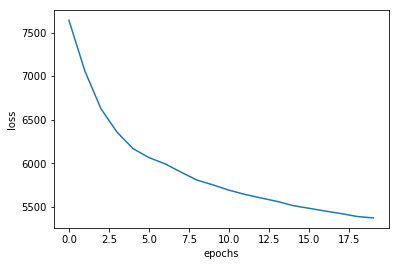

In [10]:
plt.plot(np.arange(len(history)), history)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Visualize Autoencoder Outputs

In [11]:
Xviz = Xtest[0:BATCH_SIZE]
with sess.as_default():
    Xout_val = sess.run(Xout, feed_dict={X: Xviz})

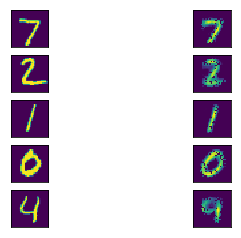

In [12]:
j = 1
for i in range(5):
    img_orig = Xviz[i].reshape(28, 28)
    img_ae = Xout_val[i].reshape(28, 28)
    plt.subplot(5, 2, j)
    plt.imshow(img_orig)
    plt.xticks([])
    plt.yticks([])
    j += 1
    plt.subplot(5, 2, j)
    plt.imshow(img_ae)
    plt.xticks([])
    plt.yticks([])
    j += 1
plt.show()

## Visualize Encoder Embeddings

In [13]:
encoder = keras.models.Model(inputs=inputs, outputs=hidden)
Z = encoder(X)

In [14]:
zvals = []
with sess.as_default():
    test_gen = datagen(Xtest, BATCH_SIZE)
    num_batches = len(Xtest) // BATCH_SIZE
    for _ in range(num_batches):
        Xbatch = test_gen.next()
        Z_val = sess.run(Z, feed_dict={X: Xbatch})
        zvals.extend(Z_val.tolist())
Z = np.array(zvals)

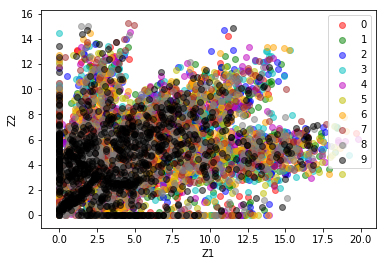

In [15]:
colors = ["r", "g", "b", "c", "m", "y", "orange", "brown", "gray", "k"]
for i in range(NUM_CLASSES):
    ytest = ytest[0:len(Z)]
    yi_indices = np.where(ytest == i)[0]
    z1 = Z[yi_indices][:, 0].tolist()
    z2 = Z[yi_indices][:, 1].tolist()
    plt.scatter(z1, z2, color=colors[i], alpha=0.5, label=str(i))
plt.legend(loc="best")
plt.xlabel("Z1")
plt.ylabel("Z2")
plt.show()